In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

#### Detecting Multicollinearity

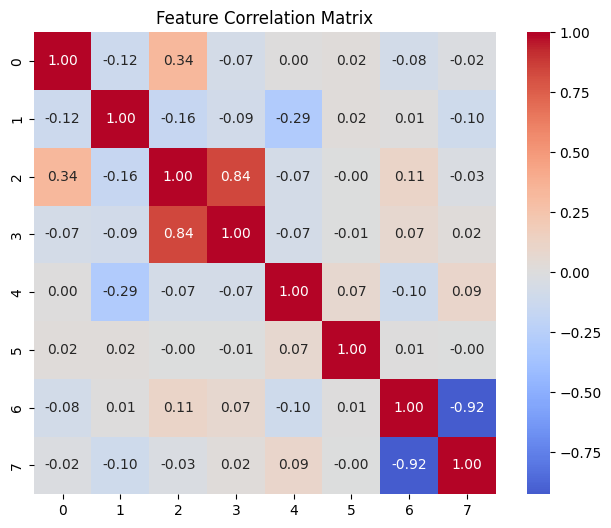

Highly correlated feature pairs (>0.8):
  2 - 3: 0.836
  6 - 7: -0.924


In [3]:
correlation_metrix = pd.DataFrame(X_train_scaled).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_metrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_metrix.columns)):
    for j in range(i+1, len(correlation_metrix.columns)):
        if abs(correlation_metrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_metrix.columns[i],
                correlation_metrix.columns[j],
                correlation_metrix.iloc[i, j]
            ))

print("Highly correlated feature pairs (>0.8):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} - {feat2}: {corr:.3f}")

**Variance Inflation Factor (VIF)**

In [4]:
def calculate_vif(x):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = range(x.shape[1])
    vif_data['VIF'] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    return vif_data

vif_df = calculate_vif(X_train_scaled)
print("\nVariance Inflation Factors:")
print(vif_df)

# Features with VIF > 10 have multicollinearity
high_vif = vif_df[vif_df['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\nFeatures with high VIF (>10): {len(high_vif)}")
    print("Consider removing or combining these features")


Variance Inflation Factors:
   Feature       VIF
0        0  2.539815
1        1  1.237337
2        2  7.917240
3        3  6.609200
4        4  1.134824
5        5  1.009733
6        6  9.206134
7        7  8.875984


#### Handling Multicollinearity
**Remove Highly Correlated Features**

In [5]:
features_to_remove = set()
for feat1, feat2, corr in high_corr_pairs:
    corr1 = np.corrcoef(X_train[:, int(feat1)], y_train)[0, 1]
    corr2 = np.corrcoef(X_train[:, int(feat2)], y_train)[0, 1]
    if abs(corr1) < abs(corr2):
        features_to_remove.add(int(feat1))
    else:
        features_to_remove.add(int(feat2))
        

x_reduced = np.delete(X_train_scaled, list(features_to_remove), axis=1)

print(features_to_remove)

{3, 7}


**Use Regularization (Ridge/Lasso)**

In [8]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


**Principal Component Analysis (PCA)**

In [11]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train_scaled)

model_pca = LinearRegression()
model_pca.fit(X_pca, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Feature Transformations

**Log Transformation**

C:\Users\User\AppData\Local\Temp\ipykernel_16012\494626248.py:2: RuntimeWarning: invalid value encountered in log1p
  X_log = np.log1p(X)  # log1p = log(1+x), handles zeros


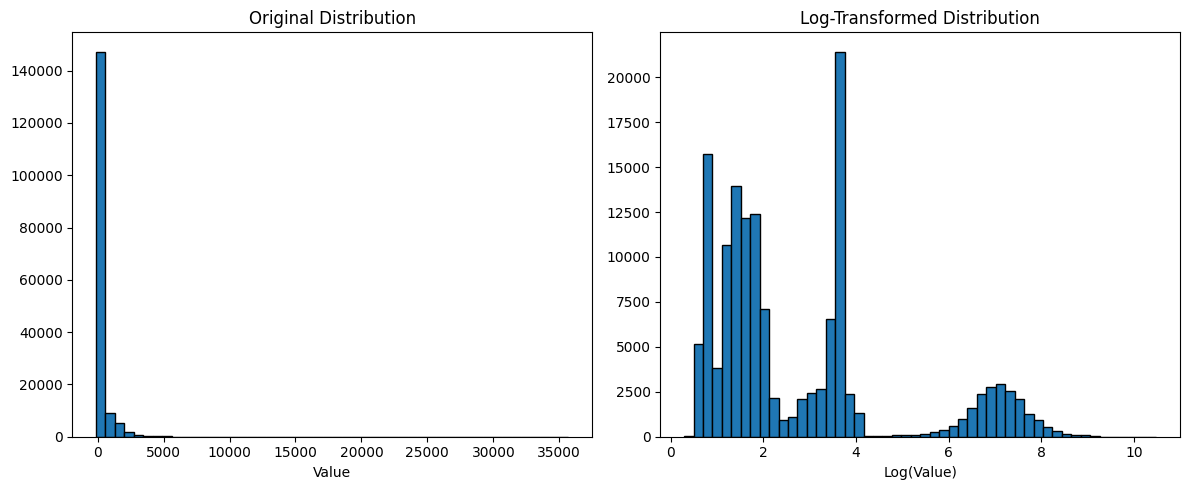

In [12]:
# For right-skewed data
X_log = np.log1p(X)  # log1p = log(1+x), handles zeros


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(X.flatten(), bins=50, edgecolor='black')
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Value')

axes[1].hist(X_log.flatten(), bins=50, edgecolor='black')
axes[1].set_title('Log-Transformed Distribution')
axes[1].set_xlabel('Log(Value)')
plt.tight_layout()
plt.show()

**Square Root Transformation**

In [13]:
# For moderately skewed data
X_sqrt = np.sqrt(X)

C:\Users\User\AppData\Local\Temp\ipykernel_16012\1498561149.py:2: RuntimeWarning: invalid value encountered in sqrt
  X_sqrt = np.sqrt(X)


**Box-Cox Transformation**

In [15]:
# Box-Cox requires positive values
X_positive = X - X.min() + 1
X_boxcox, lambda_param = stats.boxcox(X_positive.flatten())

print(f"Optimal lambda: {lambda_param:.3f}")

Optimal lambda: 0.110


**Polynomial Features**

In [ ]:
# Create polynomial features (already covered in main guide)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)